`Course Instructor`: **John Chiasson**

`Author (TA)`: **Ruthvik Vaila**

# Notes:
* In this notebook we shall load a large `NumPy` array directly into RAM to train a model.
* While the model is training keep an eye on the time taken and RAM usage of your machine.
* Tested on `Python 3.7.5` with `Tensorflow 1.15.0` and `Keras 2.2.4`. 
* Tested on `Python 2.7.17` with `Tensorflow 1.15.3` and `Keras 2.2.4`. 

# Imports

In [3]:
import sys, os
sys.version

'3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]'

In [4]:
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0" #setting it to -1 hides the GPU.
#tf.compat.v1.enable_eager_execution()
from tensorflow.python.client import device_lib
import numpy as np
import IPython
import sys, pickle, os, gzip
#import h5py, time
import IPython.display as display
from keras.utils import to_categorical
import keras, warnings
import matplotlib.pyplot as plt
import feature_reconstruction as fs
warnings.filterwarnings(action='once')
# GPU specific settings
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = InteractiveSession(config=config)
# this make sure that if using a gpu total gpu memory is not gobbled
# up by tensorflow and allows growth as required
##https://github.com/tensorflow/tensorflow/issues/24828
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau# early stopping

Using TensorFlow backend.


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    
  # Create 2 virtual GPUs with 1GB memory each
    try:
        
        tf.config.experimental.set_virtual_device_configuration(
             gpus[0],
             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
              tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        
    # Virtual devices must be set before GPUs have been initialized
        print(e)

C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
device_lib.list_local_devices()

C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17003824964315012641]

In [4]:
print('TF version:{}, Keras version:{}'.format(tf.__version__, keras.__version__))

TF version:1.15.0, Keras version:2.2.4


# Load the data
* There are `60000` images in the training set and each image needs to be of size `(28, 28, 1)` for `Keras`. The extra dimension in `(28, 28, 1)` indicates number of channels. In this case we have `1` channel because it's a gray scale image. In datasets like `CIFAR-10`, `CIFAR-100`, and `ImageNet` images have `3` channels `(RGB)`. 

In [91]:
#filename = 'data/mnist.pkl.gz'
filename = 'data/emnist-balanced.pkl.gz'
filehandle = gzip.open(filename, 'rb')
train_data, val_data, test_data = pickle.load(filehandle, encoding='latin1')
#train_data, val_data, test_data = pickle.load(filehandle)
filehandle.close()
train_x, train_y = train_data
print('train_x.shape:{} and train_y.shape:{}'.format(train_x.shape, train_y.shape))
val_x, val_y = val_data
print('val_x.shape:{} and val_y.shape:{}'.format(val_x.shape, val_y.shape))
print('images are 28*28 = 784 vectors')
#print(train_x[0]) # images are float32, normalized, and 784 vectors
print('')
# combine train and validation data as Keras will split it internally
train_x = np.concatenate([train_x, val_x], axis=0)
train_y = np.concatenate([train_y, val_y], axis=0)
print('train_x.shape:{}'.format(train_x.shape))
print('train_y.shape:{}'.format(train_y.shape))
print('')
print('train_x[0].shape:{}'.format(train_x.shape[0]))
print('train_x[1].shape:{}'.format(train_x.shape[1]))
print('')
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)#1, 28, 28, order="A")#28, 28, 1)
print('train_x.shape:{}'.format(train_x.shape))
print('train_y.shape:{}'.format(train_y.shape))
print('train_x[59999].shape: {}'.format(train_x[59999].shape))
#print('train_x[0]: {}'.format(train_x[0]))
print('')
test_x, test_y = test_data
print('test_x.shape:{}'.format(test_x.shape))
test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)#1, 28, 28, order="A")#28, 28, 1)
print('test_x.shape:{}'.format(test_x.shape))
print('test_y.shape:{}'.format(test_y.shape))
#train_x.shape[0]


train_x.shape:(99999, 784) and train_y.shape:(99999,)
val_x.shape:(12800, 784) and val_y.shape:(12800,)
images are 28*28 = 784 vectors

train_x.shape:(112799, 784)
train_y.shape:(112799,)

train_x[0].shape:112799
train_x[1].shape:784

train_x.shape:(112799, 28, 28, 1)
train_y.shape:(112799,)
train_x[59999].shape: (28, 28, 1)

test_x.shape:(18800, 784)
test_x.shape:(18800, 28, 28, 1)
test_y.shape:(18800,)


## One hot vectorize labels

In [92]:
train_y = to_categorical(train_y)
print('train_y.shape:{}'.format(train_y.shape))

test_y = to_categorical(test_y)
print('test_y.shape:{}'.format(test_y.shape))
train_y[0]

train_y.shape:(112799, 47)
test_y.shape:(18800, 47)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

## Visualize the dataset.
* The toggle command `ctrl + /` comments/uncomments multiple lines of code

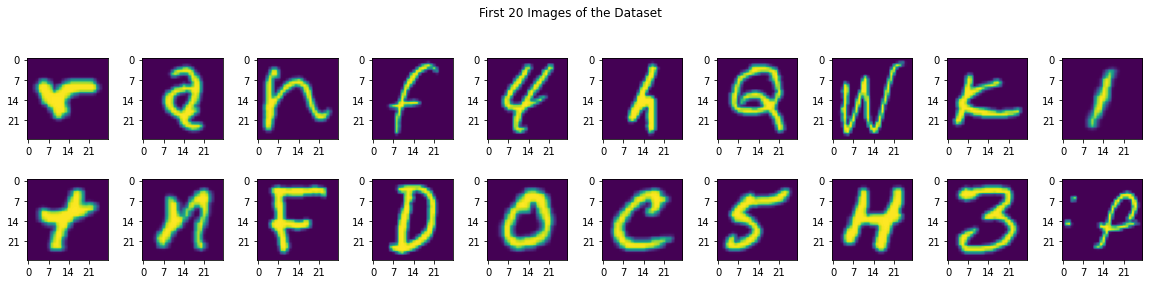

In [7]:
fig, axes = plt.subplots(2, 10, figsize=(20,4), subplot_kw={'xticks': range(0,28,7), 'yticks': range(0,28,7)})
fig.subplots_adjust(left=0.12, bottom=0.1, right=0.9, top=0.8, wspace=0.3, hspace=0.5)
#axes is a 2 by 10 array of the memory addresses of the subplots
#print(axes)
axes = axes.flatten()  #  axes is now a 1 by 20 array of the memory addresses of the subplots
#print(fig.shape)
#print(len(axes))
for i in range(len(axes)):
    axes[i].imshow(train_x[i,:,:,0])
plt.suptitle('First 20 Images of the Dataset')
plt.show()

#### Setup a small CNN model using `tf.keras.Sequential` 
* A simple convolutional neural network with the structure
* `32c32p64c64p->200->10`
* `Adam optimizer` and `Cross Entropy Loss` with a learning rate ($\alpha$) set to `0.005`.

# Case 1: 

In [51]:
eta = 0.0005
val_frac = 0.1 #Fraction of training data to be used for validation 
# FIRST CONVOLUTION LAYER
nC1_kernels = 128 ##number of kernels in the first convolutional layer
C1_kernel_shape = (3, 3) ## size of the kernel in the first convolutional layer (5,5)
C1_stride = (1,1) ## stride of the convolution 1 pixel right and 1 pixel down 
C1_activation = 'relu' ## activation function of the C1 neurons
P1_kernel_shape = (3, 3) ## Size of the pooling window (2,2) 
P1_stride = 2 ## stride of the pooling window

# SECOND CONVOLUTION LAYER
nC2_kernels = 256
C2_kernel_shape = (3, 3)  # kernel weight is really 3x3x32
C2_stride = 1
C2_activation = 'relu'
P2_kernel_shape = (3, 3)
P2_stride = 2

# FULLY CONNECTED LAYER
n_dense = 400
dense_activation = 'relu'

# FINAL LAYER
last_activation = 'softmax'
cost_function = 'categorical_crossentropy'
n_out = 47#10
optimizer = 'adam' #'sgd'

In [52]:
# help(tf.keras.layers.Conv2D)
# Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), 
#        activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
#        kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
#        bias_constraint=None, **kwargs)

In [53]:
model = tf.keras.Sequential()

#FIRST CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC1_kernels, C1_kernel_shape, C1_stride, activation=C1_activation,
                                input_shape=(28, 28, 1)))
# The 32 maps are 24x24   # 28-5+1 = 24
model.add(tf.keras.layers.MaxPooling2D(P1_kernel_shape, P1_stride))
# The 32 pooled maps are 12x12  
#SECOND CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC2_kernels, C2_kernel_shape, C2_stride, activation=C2_activation))
# The 64 maps are 10x10   (12-3+1 = 10)
model.add(tf.keras.layers.MaxPooling2D(P2_kernel_shape, P2_stride))
# The 64 pooled maps are 5x5
model.add(tf.keras.layers.Flatten())
# This makes the 64 pooled 5x5 neuronal maps into a single 25*64 = 1600 neuron layer
#FULLY CONNECTED LAYERS
model.add(tf.keras.layers.Dense(n_dense, activation=dense_activation))
model.add(tf.keras.layers.Dense(n_out, activation=last_activation))

#COMPILE THE MODEL
if(optimizer=='adam'):
    optim = tf.keras.optimizers.Adam(lr=eta)
else:
    optim = tf.keras.optimizers.SGD(lr=eta)
    
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
print(model.summary())

#CALLBACK TO KERAS TO SAVE BEST MODEL WEIGHTS
best_weights="cnn_weights_best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights, monitor='val_acc', verbose=1, save_best_only=True,
                                                mode='max')


C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\tensorflow_core\python\framework\tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 256)       295168    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 400)               1638800   
_________________________________________________________________
dense_17 (Dense)             (None, 47)               

## Train the CNN

In [54]:
mini_batch_size = 16
history = model.fit(train_x,train_y, epochs=6, batch_size=mini_batch_size, callbacks=[checkpoint],
                   validation_split=val_frac)
# val_frac is fraction of the training data taken to be validation data

C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\tensorflow_core\python\framework\tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Train on 101519 samples, validate on 11280 samples
Epoch 1/6
101504/101519 [============================>.] - ETA: 0s - loss: 0.5894 - acc: 0.8079
Epoch 00001: val_acc improved from -inf to 0.85434, saving model to cnn_weights_best.hdf5
101519/101519 [==============================] - 1098s 11ms/sample - loss: 0.5894 - acc: 0.8080 - val_loss: 0.3998 - val_acc: 0.8543
Epoch 2/6
101504/101519 [============================>.] - ETA: 0s - loss: 0.3519 - acc: 0.8742
Epoch 00002: val_acc improved from 0.85434 to 0.86968, saving model to cnn_weights_best.hdf5
101519/101519 [==============================] - 1062s 10ms/sample - loss: 0.3519 - acc: 0.8743 - val_loss: 0.3503 - val_acc: 0.8697
Epoch 3/6
101504/101519 [============================>.] - ETA: 0s - loss: 0.2978 - acc: 0.8892
Epoch 00003: val_acc improved from 0.86968 to 0.87358, saving model to cnn_weights_best.hdf5
101519/101519 [==============================] - 1080s 11ms/sample - loss: 0.2978 - acc: 0.8892 - val_loss: 0.3482 - va

# Test the model at the end

In [55]:
model.evaluate(test_x, test_y, batch_size=len(test_x))

C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


18800/18800 [==============================] - 41s 2ms/sample - loss: 0.3610 - acc: 0.8823


[0.3610430955886841, 0.8822872]

# Test at the best validation accuracy

In [56]:
model.load_weights(best_weights)
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
model.evaluate(test_x, test_y, batch_size=len(test_x))

18800/18800 [==============================] - 38s 2ms/sample - loss: 0.3610 - acc: 0.8823


[0.3610430955886841, 0.8822872]

### Plotting accuracy

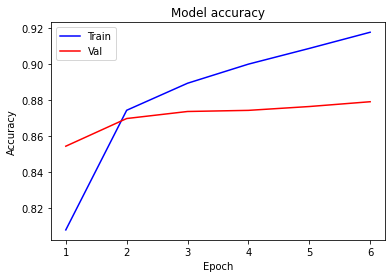

In [61]:
def plotgraph(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plotgraph(epochs, acc, val_acc)

### Plotting loss 

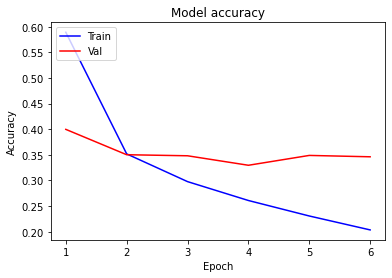

In [62]:
plotgraph(epochs, loss, val_loss)

# Case 2:

Data augumentatation 

In [93]:
batch_size = 16
gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        data_format='channels_first')  # randomly flip images

batches = gen.flow(train_x, train_y, batch_size=batch_size)
test_batches = gen.flow(test_x, test_y, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))
img = train_x[3333]
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape



C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\keras\preprocessing\image.py:440: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:
C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (112799, 28, 28, 1) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (18800, 28, 28, 1) (28

(28, 28, 1)

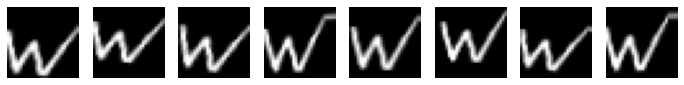

In [77]:
# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[0], cmap='gray')

In [94]:
model = tf.keras.Sequential()

#FIRST CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC1_kernels, C1_kernel_shape, C1_stride, activation=C1_activation,
                                input_shape=(28, 28, 1)))
# The 32 maps are 24x24   # 28-5+1 = 24
model.add(tf.keras.layers.MaxPooling2D(P1_kernel_shape, P1_stride))
model.add(tf.keras.layers.Dropout(0.25))
# The 32 pooled maps are 12x12  
#SECOND CONVOLUTION LAYER
model.add(tf.keras.layers.Conv2D(nC2_kernels, C2_kernel_shape, C2_stride, activation=C2_activation))
# The 64 maps are 10x10   (12-3+1 = 10)
model.add(tf.keras.layers.MaxPooling2D(P2_kernel_shape, P2_stride))
model.add(tf.keras.layers.Dropout(0.25))
# The 64 pooled maps are 5x5
model.add(tf.keras.layers.Flatten())
# This makes the 64 pooled 5x5 neuronal maps into a single 25*64 = 1600 neuron layer
#FULLY CONNECTED LAYERS
model.add(tf.keras.layers.Dense(n_dense, activation=dense_activation))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(n_out, activation=last_activation))

#COMPILE THE MODEL
if(optimizer=='adam'):
    optim = tf.keras.optimizers.Adam(lr=eta)
else:
    optim = tf.keras.optimizers.SGD(lr=eta)
    
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
print(model.summary())

#CALLBACK TO KERAS TO SAVE BEST MODEL WEIGHTS
best_weights="cnn_weights_best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights, monitor='val_acc', verbose=1, save_best_only=True,
                                                mode='max')

C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\tensorflow_core\python\framework\tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 10, 10, 256)       295168    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4096)            

In [96]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,
        data_format='channels_first')  # randomly flip images


datagen.fit(train_x)

In [98]:
mini_batch_size = 16
checkpointer = ModelCheckpoint('model-emnist-cnn.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=5, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00005)
#history = model.fit_generator(datagen.flow(train_x,train_y,batch_size=mini_batch_size), epochs=10,validation_data = (test_x, test_y), 
                              #verbose = 2, steps_per_epoch=train_x.shape[0], callbacks=[checkpoint])
history = model.fit_generator(datagen.flow(train_x,train_y,batch_size=mini_batch_size), epochs=10,validation_data = (test_x, test_y), 
                              callbacks=[checkpoint])
# val_frac is fraction of the training data taken to be validation data

C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Miniconda3\envs\Deep1\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (112799, 28, 28, 1) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/10
18800/7050 [================================================================================] - 52s 3ms/sample - loss: 0.4272 - acc: 0.8631

Epoch 00001: val_acc improved from -inf to 0.86314, saving model to cnn_weights_best.hdf5
7050/7050 [==============================] - 1557s 221ms/step - loss: 0.6774 - acc: 0.7793 - val_loss: 0.3983 - val_acc: 0.8631
Epoch 2/10
18800/7050 [================================================================================] - 68s 4ms/sample - loss: 0.4190 - acc: 0.8673

Epoch 00002: val_acc improved from 0.86314 to 0.86729, saving model to cnn_weights_best.hdf5
7050/7050 [==============================] - 1613s 229ms/step - loss: 0.5184 - acc: 0.8243 - val_loss: 0.3752 - val_acc: 0.8673
Epoch 3/10
18800/7050 [================================================================================] - 59s 3ms/sample - loss: 0.4444 - acc: 0.8745

Epoch 00003: val_acc improved from 0.86729 to 0.87447, saving model to cnn_weights_best.hdf5
7050/7050 [=

In [99]:
model.evaluate(test_x, test_y, batch_size=len(test_x))

18800/18800 [==============================] - 62s 3ms/sample - loss: 0.3185 - acc: 0.8897


[0.3185387849807739, 0.889734]

In [100]:
model.load_weights(best_weights)
model.compile(optimizer=optim, loss=cost_function, metrics=['accuracy'])
model.evaluate(test_x, test_y, batch_size=len(test_x))

18800/18800 [==============================] - 53s 3ms/sample - loss: 0.3185 - acc: 0.8897


[0.3185387849807739, 0.889734]

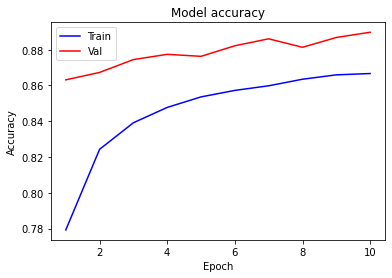

In [101]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plotgraph(epochs, acc, val_acc)

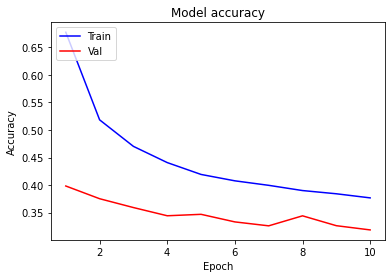

In [102]:
plotgraph(epochs, loss, val_loss)

# Inspect the Conv1 Kernel Weights

In [16]:
print("model.layers is a list of 7 objects")
print(type(model.layers),len(model.layers))
print("")
print("These 7 objects are:")
print("(1) weights & biases of Conv1")
print("(2) weights & biases of Pool1")
print("(3) weights & biases of Conv2")
print("(4) weights & biases of Pool2")
print("(5) weights & biases of the flatten layer")
print("(6) weights & biases of the first dense layer")
print("(7) weights & biases of the (dense) ouput layer")
print("")
print("Kernal Weights from input to feature map 32 of Conv1")
print('')
print(model.layers[0].get_weights()[0][:,:,0,31])  # 5x5x1   5x5x3
print('')
print("Biases of all 32 maps of the first convolutional layer")
print('')
print(model.layers[0].get_weights()[1])
print("")
print("Kernal Weights from Conv1 layer to the Pool1 layer")
print('')
print(model.layers[1].get_weights())
print('')
print("Bias of all 32 maps of the Pool1 layer")
print('')
print(model.layers[1].get_weights())

model.layers is a list of 7 objects
<class 'list'> 7

These 7 objects are:
(1) weights & biases of Conv1
(2) weights & biases of Pool1
(3) weights & biases of Conv2
(4) weights & biases of Pool2
(5) weights & biases of the flatten layer
(6) weights & biases of the first dense layer
(7) weights & biases of the (dense) ouput layer

Kernal Weights from input to feature map 32 of Conv1

[[-1.4830707e-01 -2.7987566e-03 -1.1470411e-01 -6.5549202e-02
  -2.1362022e-02]
 [-7.0915446e-02 -2.1859302e-01 -1.4181304e-01 -1.6108841e-01
  -1.7128697e-01]
 [ 7.1876913e-02 -7.9401798e-05 -8.3108187e-02 -7.9788342e-02
  -8.9337640e-02]
 [ 4.6937279e-02  2.2884885e-02  1.1973591e-01  1.2763399e-01
   5.1963046e-02]
 [ 1.1346567e-01  9.7425185e-02  2.6246099e-02  6.8243802e-02
   1.5553346e-01]]

Biases of all 32 maps of the first convolutional layer

[-0.01352519  0.01120278 -0.00725322 -0.02264073  0.0232893  -0.00613594
  0.03449872  0.01134555 -0.02640506 -0.02994598  0.0238454  -0.01439696
 -0.000156

## Get all the weights and biases of the Network

In [17]:
#Conv1 

conv1_kernels = model.layers[0].get_weights()[0]
print('conv1_kernels.shape:{}'.format(conv1_kernels.shape))
conv1_biases = model.layers[0].get_weights()[1]
print('conv1_biases.shape:{}\n'.format(conv1_biases.shape))

#Conv2 
# It is model.layers[2] instead of model.layers[1] because model.layers[1] is a pooling layer
# and pooling layers have neither biases nor weights

conv2_kernels = model.layers[2].get_weights()[0]
print('conv2_kernels.shape:{}'.format(conv2_kernels.shape))
conv2_biases = model.layers[2].get_weights()[1]
print('conv2_biases.shape:{}\n'.format(conv2_biases.shape))
# model.layers[3] are the weights & biases of the pooling layer
# model.layers[4] are the weights & biases of the flatten layer
#First fully connected layer
# it's  model.layers[5] because model.layers[3] is a pooling layer and model.layers[4] is a
# flattening "layer"
fcn1_weights = model.layers[5].get_weights()[0]
print('fcn1_weights.shape:{}'.format(fcn1_weights.shape))
fcn1_biases = model.layers[5].get_weights()[1]
print('fcn1_biases.shape:{}\n'.format(fcn1_biases.shape))
fcn2_weights = model.layers[6].get_weights()[0]
print('fcn2_weights.shape:{}'.format(fcn2_weights.shape))
fcn2_biases = model.layers[6].get_weights()[1]
print('fcn2_biases.shape:{}\n'.format(fcn2_biases.shape))
#print(fcn2_weights.astype(np.float16))
#print(fcn2_biases)

conv1_kernels.shape:(5, 5, 1, 32)
conv1_biases.shape:(32,)

conv2_kernels.shape:(3, 3, 32, 64)
conv2_biases.shape:(64,)

fcn1_weights.shape:(1600, 200)
fcn1_biases.shape:(200,)

fcn2_weights.shape:(200, 10)
fcn2_biases.shape:(10,)



# Visualize `Conv1` weights

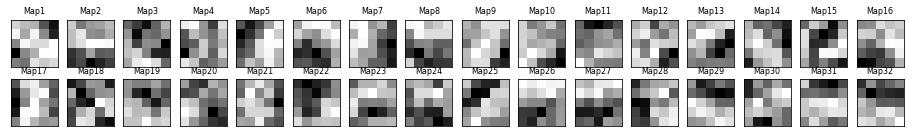

In [18]:
fig, axes = plt.subplots(2, 16, figsize=(16,2), subplot_kw={'xticks': [], 'yticks': []})
#fig.subplots_adjust(left=0.12, bottom=0.5, right=0.89, top=0.9, wspace=0.1, hspace=0.21)
axes = axes.flatten()
for i in range(len(axes)):
    axes[i].imshow(conv1_kernels[:,:,0,i], cmap='gray')
    axes[i].set_title('Map'+str(i+1), fontsize=8)
#plt.suptitle('Conv1 Kernels')
plt.show()
# imshow normalizes the kernel weights to between 0 and 1, then converts them to grayscale 0 to 255
# black is 0 and white is 255

# Difference of Gaussian.
* [Read](https://en.wikipedia.org/wiki/Gaussian_function#Two-dimensional_Gaussian_function)
* [Read](https://en.wikipedia.org/wiki/Difference_of_Gaussians)

[[ 0.06396 -0.01121 -0.07825 -0.10315 -0.07825 -0.01121  0.06396]
 [-0.01121 -0.1276  -0.1613  -0.1315  -0.1613  -0.1276  -0.01121]
 [-0.07825 -0.1613   0.1166   0.433    0.1166  -0.1613  -0.07825]
 [-0.10315 -0.1315   0.433    1.       0.433   -0.1315  -0.10315]
 [-0.07825 -0.1613   0.1166   0.433    0.1166  -0.1613  -0.07825]
 [-0.01121 -0.1276  -0.1613  -0.1315  -0.1613  -0.1276  -0.01121]
 [ 0.06396 -0.01121 -0.07825 -0.10315 -0.07825 -0.01121  0.06396]]

dog1.shape is (7, 7)


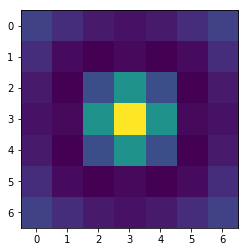

In [23]:
dog1 = fs.DoG(7, 1.0, 2.0)
print(dog1.astype(np.float16))
plt.imshow(dog1)
print("")
print('dog1.shape is {}'.format(dog1.shape))

[[-0.3965  0.0695  0.485   0.6396  0.485   0.0695 -0.3965]
 [ 0.0695  0.7905  1.      0.815   1.      0.7905  0.0695]
 [ 0.485   1.     -0.7227 -2.686  -0.7227  1.      0.485 ]
 [ 0.6396  0.815  -2.686  -6.2    -2.686   0.815   0.6396]
 [ 0.485   1.     -0.7227 -2.686  -0.7227  1.      0.485 ]
 [ 0.0695  0.7905  1.      0.815   1.      0.7905  0.0695]
 [-0.3965  0.0695  0.485   0.6396  0.485   0.0695 -0.3965]]

dog2.shape is (7, 7)


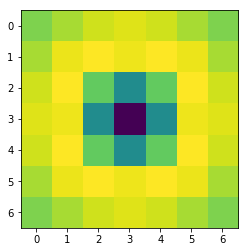

In [24]:
dog2 = fs.DoG(7, 2.0, 1.0)
print(dog2.astype(np.float16))
plt.imshow(dog2)
print("")
print('dog2.shape is {}'.format(dog2.shape))

## Setup the convolution in `tensorflow`

In [25]:
image_placeholder = tf.placeholder(tf.float32, shape=[1,28,28,1])
kernel_placeholder = tf.placeholder(tf.float32, shape=[7,7,1,1]) 
# 7x7 kernel with 1 input channels and 1 output channel/map
conv_strides_1d = [1, 1, 1, 1]
inter = tf.squeeze(tf.nn.conv2d(image_placeholder,kernel_placeholder,strides=conv_strides_1d,padding='VALID'))
sess= tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)

## Convolve with `DoG1` and Display

train_x[0,:,:,0].shape is (28, 28)


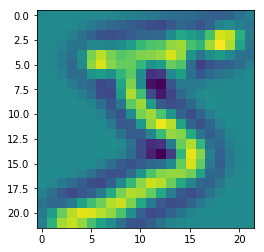

In [26]:
print('train_x[0,:,:,0].shape is {}'.format(train_x[0,:,:,0].shape))
image = train_x[0,:,:,0].reshape(1,28,28,1)
kernel = dog1.reshape(7,7,1,1)
result1 = sess.run(inter,feed_dict ={image_placeholder:image,kernel_placeholder:kernel})
plt.imshow(result1)

## Convolve with `DoG2` and Display

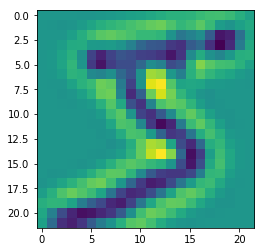

In [27]:
image = train_x[0,:,:,0].reshape(1,28,28,1)
kernel = dog2.reshape(7,7,1,1)
result2 = sess.run(inter,feed_dict ={image_placeholder:image,kernel_placeholder:kernel})
plt.imshow(result2)

# Restart the notebook to free up the `GPU` and `RAM`.

In [ ]:
IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel